# Búsqueda Local: el mejor

Se  implementarásiguiendo  los  esquemas  de el  mejor,  y  de el  primer  mejorvecino, según se explicó en el Tema 1 de teoría, usando el operador 2-opt.Se partirá de una solución inicial aleatoria.  
Los algoritmos de búsqueda local tienen su propia condición de parada, pero adicionalmente, en prevención de tiempos excesivos en algún caso, se añadirá una condición de parada alternativa (OR) basada en el número de evaluaciones que esté realizando la búsqueda, es decir, el número de vecesque se llame al cálculo de la función de coste.   
Este valor para la Búsqueda Local será de 1600·nllamadas a la función de coste.  
La búsqueda con cada algoritmo se debe ejecutar 10 veces consemillas distintas, como en el caso de la Aleatoria.

---
## Librerías
- matplotlib: necesaria para la representación de la solución.
- pandas: necesaria para la representación de resultados.
- random: necesaria para el control de números aleatorios.
- datetime: necesaria para la obtención de una semilla inicial que genere las demás semillas.
- multiprocessing: necesaria para la ejecución concurrente de las soluciones.
- itertools: necesaria para combinar las semillas con los dataset en la ejecución concurrente.
- ipynb: necesaria para cargar la función busqueda_aleatorio de otro fichero. Esto permite la ejecución concurrente en Jupyter.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from random import seed
from random import randint
from datetime import datetime
from multiprocessing import Pool, TimeoutError
import itertools
from ipynb.fs.full.algoritmo import *

---
## Funciones auxiliares
- cargar_fichero(nombre_fichero): devuelve un array con las ciudades almacenadas en el fichero. [ [ ciudad, posición x , posición y ] [...] ... ]
- calcular_distancia_euclidea(node_1,node_2): devuelve en la distancia entre las dos ciudades.
- dibujar_flecha(A, B): dibuja una flecha entre el punto A y B apuntando a B. 
- representacion(camino, nombre, distancia): representa las ciudades y el camino calculado.
- representacion_datos(result,nombre): representa la solución obtenida de la ejecución concurrente de un dataset.

In [2]:
def cargar_fichero(nombre_fichero):
    
    fichero = open( "../Dataset/" + nombre_fichero + ".tsp", 'r')
    
    for i in range(3):
        fichero.readline()
        
    numero_de_ciudades = fichero.readline().strip().split()[1]
    
    for i in range(2):
        fichero.readline()
        
    ciudades = []
    for i in range(0, int(numero_de_ciudades)):
        ciudad,x,y = fichero.readline().strip().split()[:]
        ciudades.append([int(ciudad),float(x),float(y)])  
        
    fichero.close()
    
    return ciudades

In [3]:
def calcular_distancia_euclidea(ciudad_1,ciudad_2):
    
    x1,y1 = ciudad_1[1 :]
    x2,y2 = ciudad_2[1 :]
    
    xd = x1 - x2
    yd = y1 - y2
    
    return round(math.sqrt( xd*xd + yd*yd ))

In [4]:
def dibujar_flecha(A, B):
    plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1],
              head_width=1.3, length_includes_head=True)

In [5]:
def representacion(camino, nombre, distancia):
    
    plt.figure(figsize=(10,10))
    
    for i in range(len(camino)):
        if(i == 0):
            plt.plot(camino[i][1], camino[i][2] , "o", color="green")
        else:
            plt.plot(camino[i][1], camino[i][2] , "*", color="red")
        
        if(i<len(camino)-1):
            dibujar_flecha([camino[i][1], camino[i][2]],[camino[i+1][1], camino[i+1][2]])
        else:
            dibujar_flecha([camino[i][1], camino[i][2]],[camino[0][1], camino[0][2]])
    
    plt.title(nombre + " : " + str(distancia))

In [6]:
def representacion_datos(result,nombre):
    semilla_coste = pd.DataFrame(columns=["Semilla","Coste","Nº de evaluaciones"])
    for i in range(10):
        semilla_coste.loc[len(semilla_coste)] = [semillas[i],result[i][1], result[i][2]]
    display(semilla_coste)

    print("Media coste: ", semilla_coste[['Coste']].mean()[0])
    print("Desviación típica coste: ", semilla_coste[['Coste']].std()[0])
    print("Media nº de evaluaciones: ", semilla_coste[['Nº de evaluaciones']].mean()[0])
    print("Desviación típica nº de evaluaciones: ", semilla_coste[['Nº de evaluaciones']].std()[0])


    print()
    print("Representación de la mejor solución: ")
    indice = semilla_coste[['Coste']].idxmin()[0]


    representacion(result[indice][0], nombre, result[indice][1])

---
## Función de evaluación
Esta función genera el coste total de la solución pasara por parámetro. Para ello recorre todas las ciudades de la solución sumando el coste entre ellas. 

In [7]:
def funcion_de_evaluacion(solucion):
    coste = 0
    for indice in range(len(solucion)-1):
        coste += calcular_distancia_euclidea(solucion[indice],solucion[indice+1])
    coste += calcular_distancia_euclidea(solucion[-1],solucion[0])
    return coste

---
## Lectura de ficheros y ejecución del algoritmo
Para poder ejecutar correctamente el algoritmo de forma concurrente en Jupyter, este debe ser cargado de forma externa. Para ello se ha usado la librería ipynb.

In [8]:
st70 = cargar_fichero("st70")
ch130 = cargar_fichero("ch130")
a280 = cargar_fichero("a280")
p654 = cargar_fichero("p654")
vm1084 = cargar_fichero("vm1084")
vm1748 = cargar_fichero("vm1748")

### Generación de semillas

In [9]:
semillas = []
dt = datetime.now()
for i in range(10):
    semillas.append(randint(0,dt.microsecond))
print("Semillas generadas:")
print(semillas)

Semillas generadas:
[541876, 42953, 168628, 509656, 152219, 454783, 905146, 413755, 351625, 840354]


#### st70

2.522418737411499


,Semilla,Coste,Nº de evaluaciones
0,541876.0,1123.0,112000.0
1,42953.0,1217.0,112000.0
2,168628.0,1240.0,112000.0
3,509656.0,1093.0,112000.0
4,152219.0,1176.0,112000.0
5,454783.0,1190.0,112000.0
6,905146.0,1239.0,112000.0
7,413755.0,1276.0,112000.0
8,351625.0,1255.0,112000.0
9,840354.0,1238.0,112000.0


Media coste:  1204.7
Desviación típica coste:  59.149621958029265
Media nº de evaluaciones:  112000.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


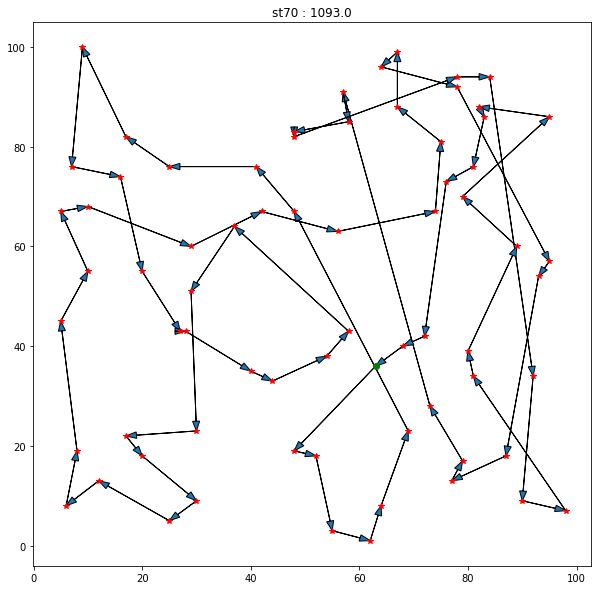

In [10]:
dataset = st70
with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_local_el_mejor,  itertools.product(semillas,[dataset]) )
representacion_datos(result,"st70")

#### ch130


,Semilla,Coste,Nº de evaluaciones
0,579516.0,23869.0,208000.0
1,425875.0,25257.0,208000.0
2,350865.0,24150.0,208000.0
3,287847.0,23409.0,208000.0
4,202042.0,23088.0,208000.0
5,384120.0,23456.0,208000.0
6,35792.0,23969.0,208000.0
7,96946.0,22965.0,208000.0
8,396706.0,23918.0,208000.0
9,250574.0,23990.0,208000.0


Media coste:  23807.1
Desviación típica coste:  650.0920362191462
Media nº de evaluaciones:  208000.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


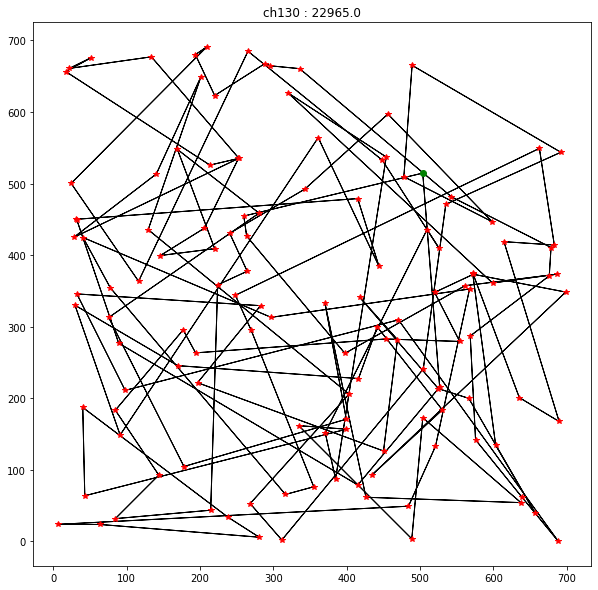

In [11]:
dataset = ch130

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_local_el_mejor,  itertools.product(semillas,[dataset]) )
    
representacion_datos(result,"ch130")

#### a280

,Semilla,Coste,Nº de evaluaciones
0,579516.0,26847.0,448000.0
1,425875.0,27750.0,448000.0
2,350865.0,27244.0,448000.0
3,287847.0,27060.0,448000.0
4,202042.0,26437.0,448000.0
5,384120.0,26534.0,448000.0
6,35792.0,27091.0,448000.0
7,96946.0,26215.0,448000.0
8,396706.0,25845.0,448000.0
9,250574.0,26753.0,448000.0


Media coste:  26777.6
Desviación típica coste:  548.5427563604825
Media nº de evaluaciones:  448000.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


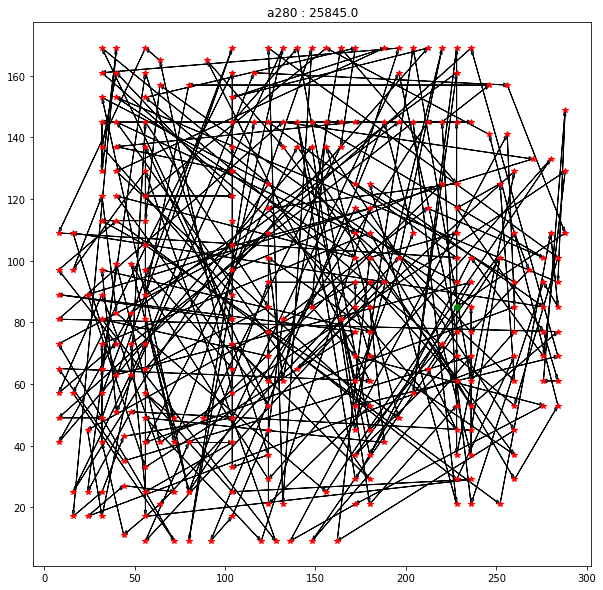

In [12]:
dataset = a280
with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_local_el_mejor,  itertools.product(semillas,[dataset]) )

representacion_datos(result,"a280")

#### p654

,Semilla,Coste,Nº de evaluaciones
0,579516.0,1923552.0,1046400.0
1,425875.0,1961384.0,1046400.0
2,350865.0,1903739.0,1046400.0
3,287847.0,1892486.0,1046400.0
4,202042.0,1914212.0,1046400.0
5,384120.0,1834428.0,1046400.0
6,35792.0,1918604.0,1046400.0
7,96946.0,1871719.0,1046400.0
8,396706.0,1959677.0,1046400.0
9,250574.0,1897952.0,1046400.0


Media coste:  1907775.3
Desviación típica coste:  38008.347203242374
Media nº de evaluaciones:  1046400.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


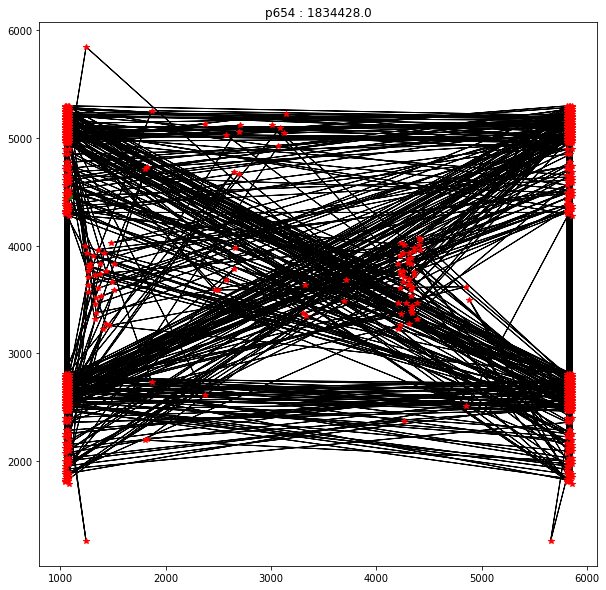

In [13]:
dataset = p654

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_local_el_mejor,  itertools.product(semillas,[dataset]) )
    
representacion_datos(result,"p654")

#### vm1084

,Semilla,Coste,Nº de evaluaciones
0,579516.0,8225182.0,1734400.0
1,425875.0,8493938.0,1734400.0
2,350865.0,8518814.0,1734400.0
3,287847.0,8386755.0,1734400.0
4,202042.0,8306411.0,1734400.0
5,384120.0,8610553.0,1734400.0
6,35792.0,8295996.0,1734400.0
7,96946.0,8550654.0,1734400.0
8,396706.0,8363378.0,1734400.0
9,250574.0,8202064.0,1734400.0


Media coste:  8395374.5
Desviación típica coste:  141652.42380500707
Media nº de evaluaciones:  1734400.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


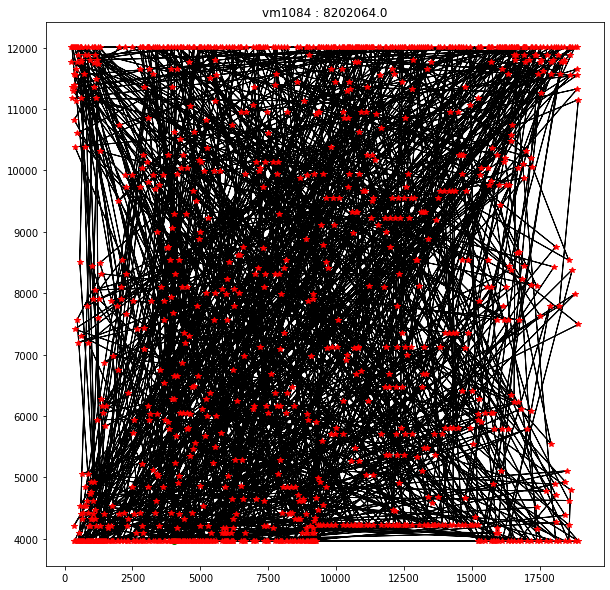

In [14]:
dataset = vm1084

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_local_el_mejor,  itertools.product(semillas,[dataset]) )
    
representacion_datos(result,"vm1084")

#### vm1748

,Semilla,Coste,Nº de evaluaciones
0,579516.0,14833688.0,2796800.0
1,425875.0,14748416.0,2796800.0
2,350865.0,14685799.0,2796800.0
3,287847.0,14869349.0,2796800.0
4,202042.0,14898671.0,2796800.0
5,384120.0,14963662.0,2796800.0
6,35792.0,14486514.0,2796800.0
7,96946.0,14650729.0,2796800.0
8,396706.0,15091604.0,2796800.0
9,250574.0,14548386.0,2796800.0


Media coste:  14777681.8
Desviación típica coste:  189175.09233030063
Media nº de evaluaciones:  2796800.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


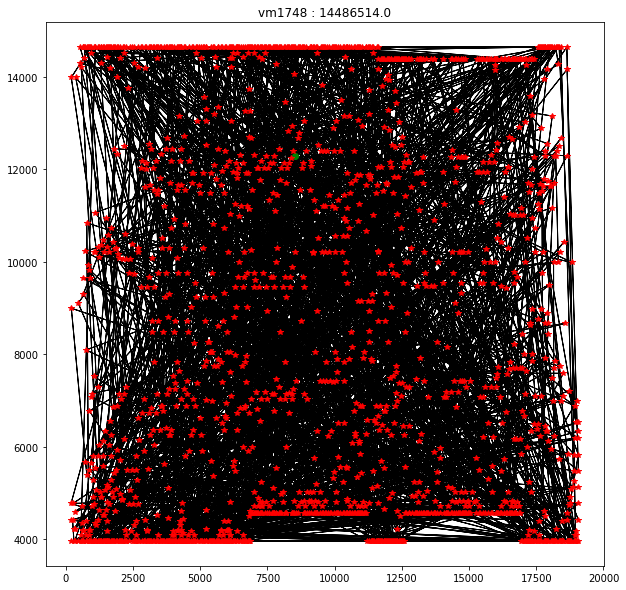

In [15]:
dataset = vm1748

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_local_el_mejor,  itertools.product(semillas,[dataset]) )
    
representacion_datos(result,"vm1748")